## Funções básicas



In [1]:
def remover_outliers_iqr(df, colunas=None, fator=1.5):
    """
    Remove outliers de colunas numéricas de um DataFrame usando o método do IQR.

    Parâmetros:
        df (pd.DataFrame): O DataFrame de entrada.
        colunas (list ou None): Lista de colunas para aplicar o filtro. Se None, aplica em todas numéricas.
        fator (float): Fator multiplicativo do IQR (padrão 1.5).

    Retorna:
        pd.DataFrame: DataFrame sem os outliers nas colunas especificadas.
    """
    df_limpo = df.copy()

    if colunas is None:
        colunas = df_limpo.select_dtypes(include='number').columns

    for col in colunas:
        Q1 = df_limpo[col].quantile(0.25)
        Q3 = df_limpo[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - fator * IQR
        limite_superior = Q3 + fator * IQR
        df_limpo = df_limpo[(df_limpo[col] >= limite_inferior) & (df_limpo[col] <= limite_superior)]

    return df_limpo

## Lendo o dataframe de microdados do ENEM
#### Execute esta célula pra reinicar o dataframe

In [2]:
import pandas as pd

# Caminho para o arquivo CSV (ajuste conforme a localização)
caminho_csv_dados_enem = "E:\\Users\\Tiago\\Feadev\\Capacitação\\Projetos\\ENEM\\microdados_enem_2023\\DADOS\\MICRODADOS_ENEM_2023.csv"

# Leitura do CSV
df_enem = pd.read_csv(caminho_csv_dados_enem, sep=';', encoding='latin1', low_memory=False)

# Exibe as primeiras linhas
print(df_enem.head())


   NU_INSCRICAO  NU_ANO  TP_FAIXA_ETARIA TP_SEXO  TP_ESTADO_CIVIL  \
0  210059085136    2023               14       M                2   
1  210059527735    2023               12       M                2   
2  210061103945    2023                6       F                1   
3  210060214087    2023                2       F                1   
4  210059980948    2023                3       F                1   

   TP_COR_RACA  TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  \
0            1                 1                1               17          1   
1            1                 0                1               16          1   
2            1                 1                1                0          1   
3            3                 1                2                0          2   
4            3                 1                2                0          2   

   ...  Q016  Q017  Q018 Q019  Q020 Q021  Q022  Q023  Q024  Q025  
0  ...     C     C     B    B  

In [85]:
colunas = ['NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
df_limpo = df_enem.dropna(subset=['NU_NOTA_MT'])  # remove linhas sem nota
media_sp = df_enem.loc[df_enem['NO_MUNICIPIO_ESC'] == 'São Paulo', colunas].mean()
print(media_sp)
print(media_sp.mean())
df_enem[df_enem['NO_MUNICIPIO_ESC'] == 'São Paulo']['NOTA_MEDIA'].mean()

NU_NOTA_CH         537.339213
NU_NOTA_LC         536.039442
NU_NOTA_CN         503.217246
NU_NOTA_MT         561.429192
NU_NOTA_REDACAO    634.297845
dtype: float64
554.4645876178963


553.8790687311279

## Tratamento de Dados

In [3]:
#Q1 = escolaridade pai, Q2 = mãe, Q5 tamanho da familia, Q6 renda familiar
colunas = [
            'Q001', 'Q002', 'Q005', 'Q006', 'TP_SEXO', 'TP_COR_RACA', 'TP_FAIXA_ETARIA','TP_ESCOLA'    #caracteristicas
            'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'                  #notas
           ]


# Remove linhas onde Q001 ou Q002 sejam 'H' (responderam com nao sei escolaridade dos pais)
df_enem = df_enem[(df_enem['Q001'] != 'H') & (df_enem['Q002'] != 'H')]

map_escolaridade1 = {
    'A': 0,  # Nunca estudou
    'B': 1,  # Não completou a 4ª série/5º ano do Ensino Fundamental.
    'C': 2,  # Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.
    'D': 3,  # Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.
    'E': 5,  # Completou o Ensino Médio, mas não completou a Faculdade.
    'F': 8,  # Completou a Faculdade, mas não completou a Pós-graduação.
    'G': 13,  # Completou a Pós-graduação.
    'H': 0,  # Não sei.
}

map_escolaridade2 = {
    'A': 0,  # Nunca estudou
    'B': 1,  # Não completou a 4ª série/5º ano do Ensino Fundamental.
    'C': 2,  # Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.
    'D': 4,  # Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.
    'E': 8,  # Completou o Ensino Médio, mas não completou a Faculdade.
    'F': 16,  # Completou a Faculdade, mas não completou a Pós-graduação.
    'G': 32,  # Completou a Pós-graduação.
    'H': 0,  # Não sei.
}


df_enem['ESC_PAI'] = df_enem['Q001'].map(map_escolaridade1)
df_enem['ESC_MAE'] = df_enem['Q002'].map(map_escolaridade1)
df_enem['ESC_PAI_MAE'] = df_enem['ESC_PAI'] + df_enem['ESC_MAE']

# Mapeia renda familiar (Q006)

map_renda2 = {
    'A': 0,     # sem renda
    'B': 660,   # Até R$ 1320
    'C': 1650,  # De R$ 1.320,01 até R$ 1.980,00
    'D': 2310,  # De R$ 1.980,01 até R$ 2.640,00
    'E': 2970,  # De R$ 2.640,01 até R$ 3.300,00
    'F': 3630,  # De R$ 3.300,01 até R$ 3.960,00
    'G': 4620,  # De R$ 3.960,01 até R$ 5.280,00
    'H': 5940,  # De R$ 5.280,01 até R$ 6.600,00
    'I': 7260,  # De R$ 6.600,01 até R$ 7.920,00
    'J': 8580,  # De R$ 7.920,01 até R$ 9.240,00
    'K': 9900,  # De R$ 9.240,01 até R$ 10.560,00
    'L': 11200, # De R$ 10.560,01 até R$ 11.880,00
    'M': 12540, # De R$ 11.880,01 até R$ 13.200,00
    'N': 14520, # De R$ 13.200,01 até R$ 15.840,00
    'O': 17820, # De R$ 15.840,01 até R$ 19.800,00
    'P': 23100, # De R$ 19.800,01 até R$ 26.400,00
    'Q': 26400, #Acima de R$ 26.400,00  
}

df_enem = df_enem[df_enem['Q005'] > 0] #familias precisam ter no minimo 1 pessoa, nao pode dividir por zero
df_enem['RENDA_CAPITA'] = df_enem['Q006'].map(map_renda2) / df_enem['Q005']


# Mapeia sexo
df_enem['SEXO'] = df_enem['TP_SEXO'].map({'F': 0, 'M': 1})

# Remove não declarados (1), escola publica muda como 0 e escola privada para 1
df_enem = df_enem[df_enem['TP_ESCOLA'] != 1]
df_enem['TP_ESCOLA'] = df_enem['TP_ESCOLA'].replace({2: 0, 3: 1})

# Nota média das 5 provas
df_enem['NOTA_MEDIA'] = df_enem[[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
    'NU_NOTA_MT', 'NU_NOTA_REDACAO'
]].mean(axis=1)

# Seleciona colunas numéricas finais
dados_numericos = df_enem[[
    'RENDA_CAPITA', 'ESC_PAI_MAE', 'SEXO', 'NOTA_MEDIA', 'TP_FAIXA_ETARIA', 'TP_ESCOLA'
]].dropna()

# Removendo outliers
df_enem = remover_outliers_iqr(df_enem, colunas=['NOTA_MEDIA'])

## Matriz de correlação entre fatores significativos
#### Escolaridade dos pais, renda per capita, cor, genero e idade

                 RENDA_CAPITA  ESC_PAI_MAE      SEXO  NOTA_MEDIA  \
RENDA_CAPITA         1.000000     0.555204  0.080068    0.393712   
ESC_PAI_MAE          0.555204     1.000000  0.082005    0.415754   
SEXO                 0.080068     0.082005  1.000000    0.010612   
NOTA_MEDIA           0.393712     0.415754  0.010612    1.000000   
TP_FAIXA_ETARIA     -0.113739    -0.197444  0.005815   -0.203438   
TP_ESCOLA            0.523668     0.477768  0.051251    0.426398   

                 TP_FAIXA_ETARIA  TP_ESCOLA  
RENDA_CAPITA           -0.113739   0.523668  
ESC_PAI_MAE            -0.197444   0.477768  
SEXO                    0.005815   0.051251  
NOTA_MEDIA             -0.203438   0.426398  
TP_FAIXA_ETARIA         1.000000  -0.138348  
TP_ESCOLA              -0.138348   1.000000  


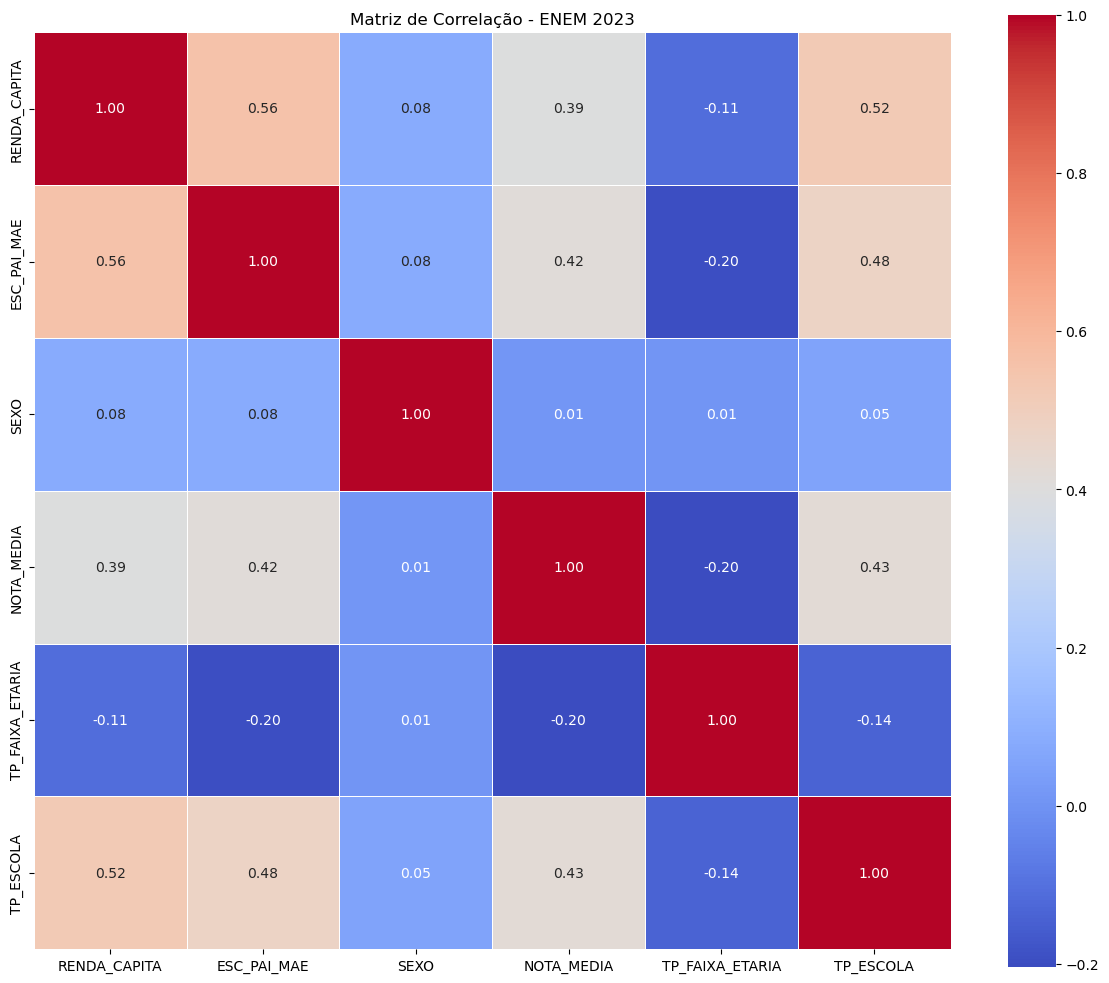

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Matriz de correlação
matriz_corr = dados_numericos.corr()

# Exibe
print(matriz_corr)

# Plota heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Matriz de Correlação - ENEM 2023")

# Rotaciona os nomes dos eixos X
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('plots/Matrizes/Correlação de fatores.png', dpi=300) # Salva o plot na subpaste de plots
plt.show()


## Analise da distribuição Geográfica das notas
#### Plota um gráfica de desempenho por nota para cada estado

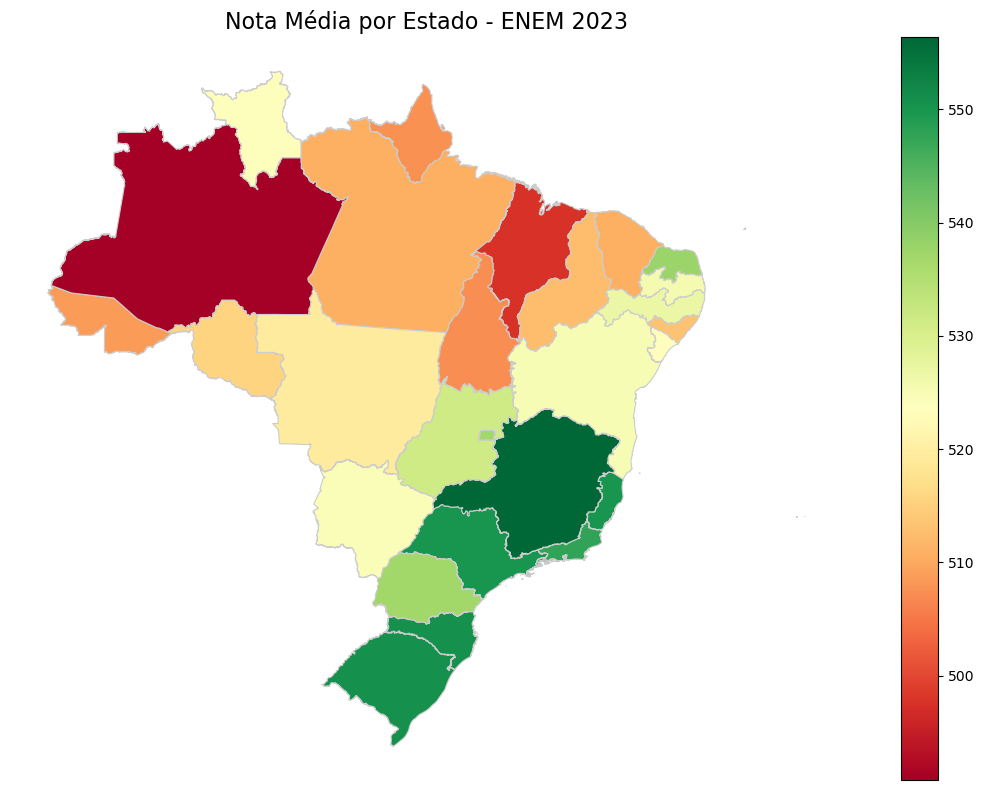

In [108]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

brasil = gpd.read_file("Dados/BR_UF_2024/BR_UF_2024.shp") ##shape file do IBGE: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html


# Remove candidatos com alguma nota faltando
df_validos = df_enem.dropna(subset=[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
    'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'SG_UF_PROVA'
])

# Agrupa por estado (UF) e calcula média das notas
media_por_uf = df_validos.groupby('SG_UF_PROVA')['NOTA_MEDIA'].mean().reset_index()

# Carrega o shapefile dos estados brasileiros
brasil = gpd.read_file("Dados/BR_UF_2024/BR_UF_2024.shp")


# Junta os dados do ENEM com o mapa usando a sigla do estado
mapa_dados = brasil.merge(media_por_uf, left_on='SIGLA_UF', right_on='SG_UF_PROVA')

# Plota o mapa
fig, ax = plt.subplots(figsize=(12, 8))
mapa_dados.plot(column='NOTA_MEDIA', cmap='RdYlGn', linewidth=0.8, edgecolor='0.8',
                legend=True, ax=ax)

ax.set_title('Nota Média por Estado - ENEM 2023', fontsize=16)
ax.axis('off')
plt.tight_layout()

plt.savefig('plots/Mapas/Medias_por_UF.png', dpi=300) # Salva o plot na subpaste de plots

plt.show()



## Mapas de IDH

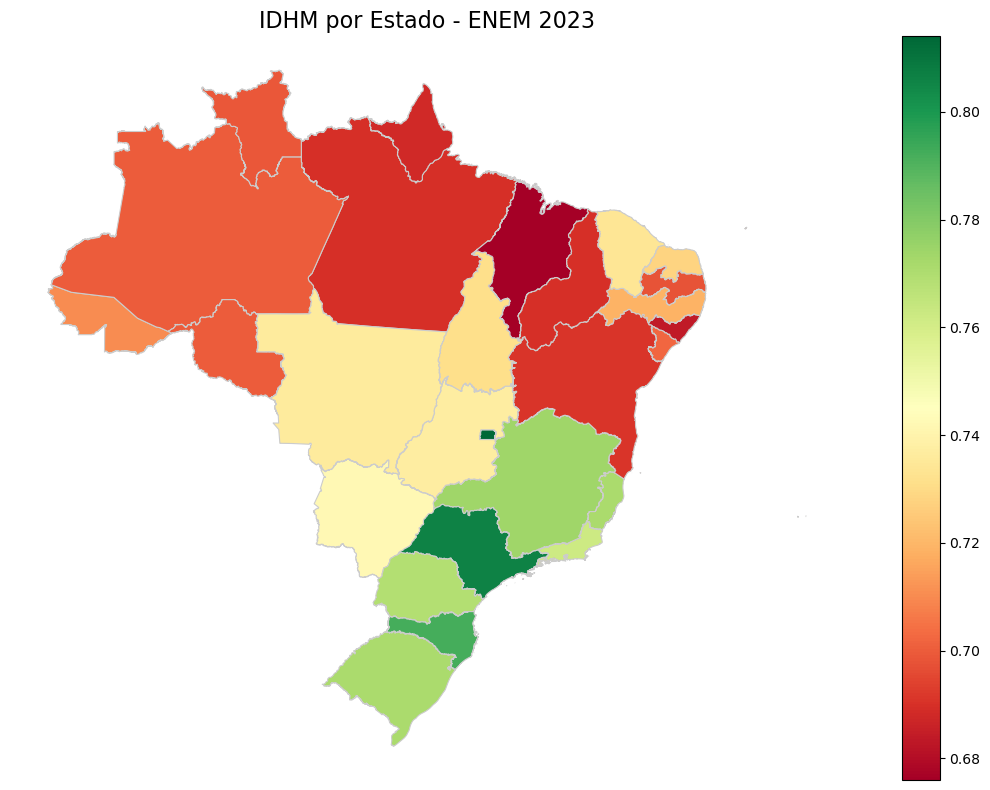

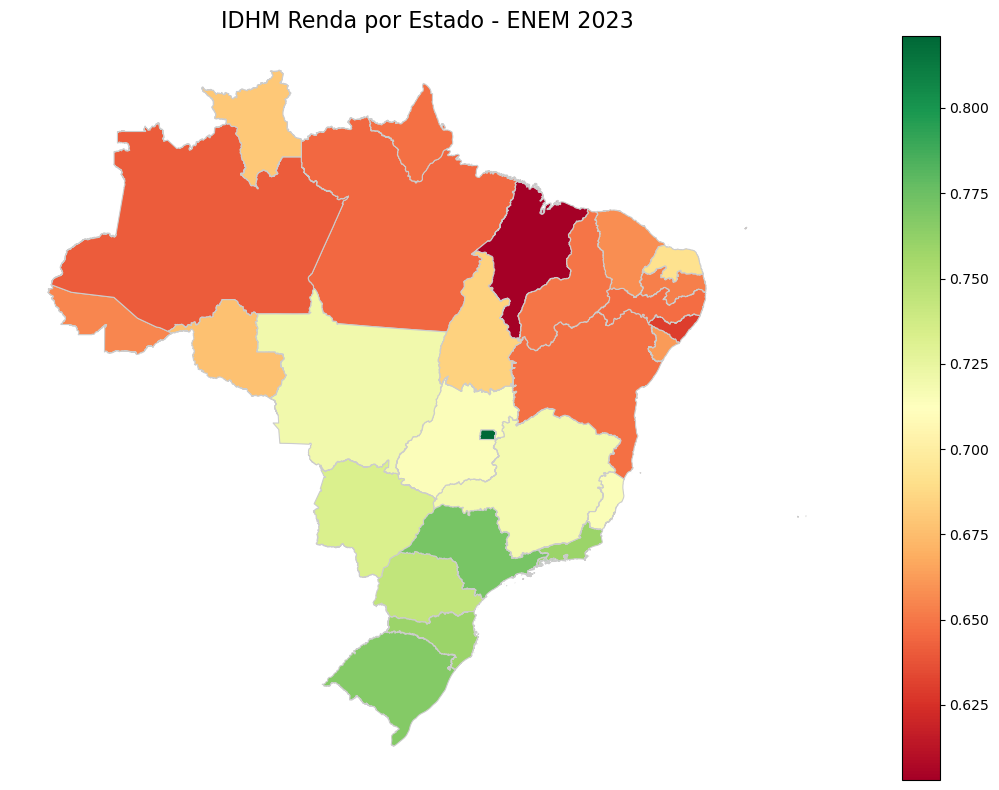

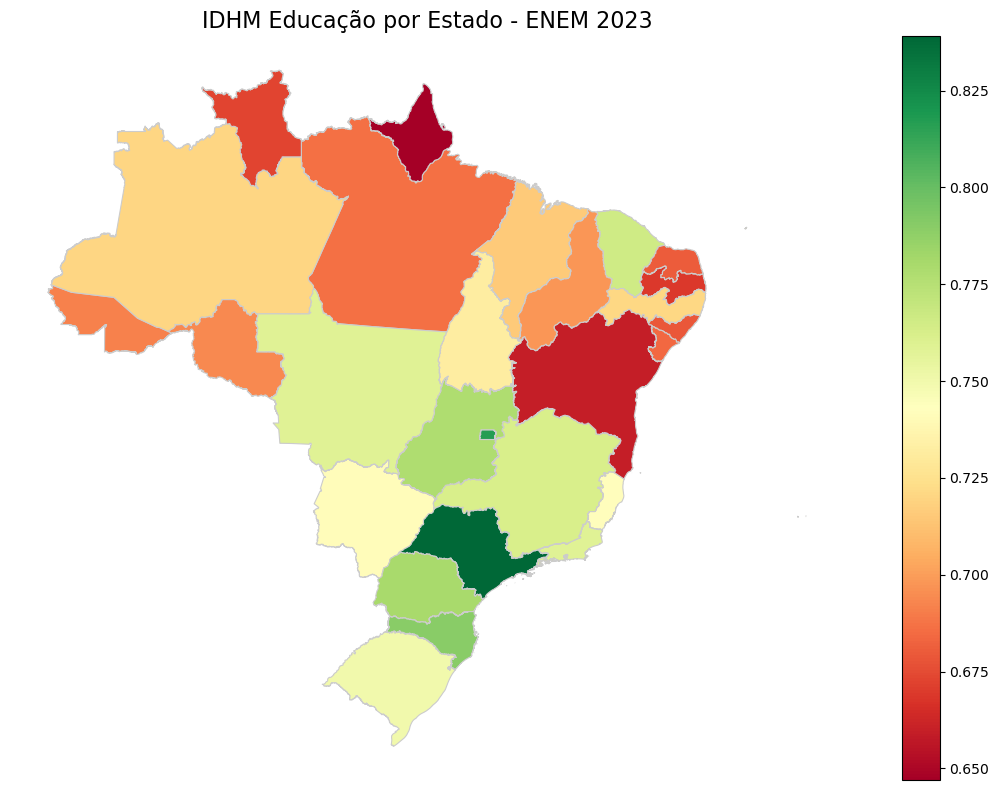

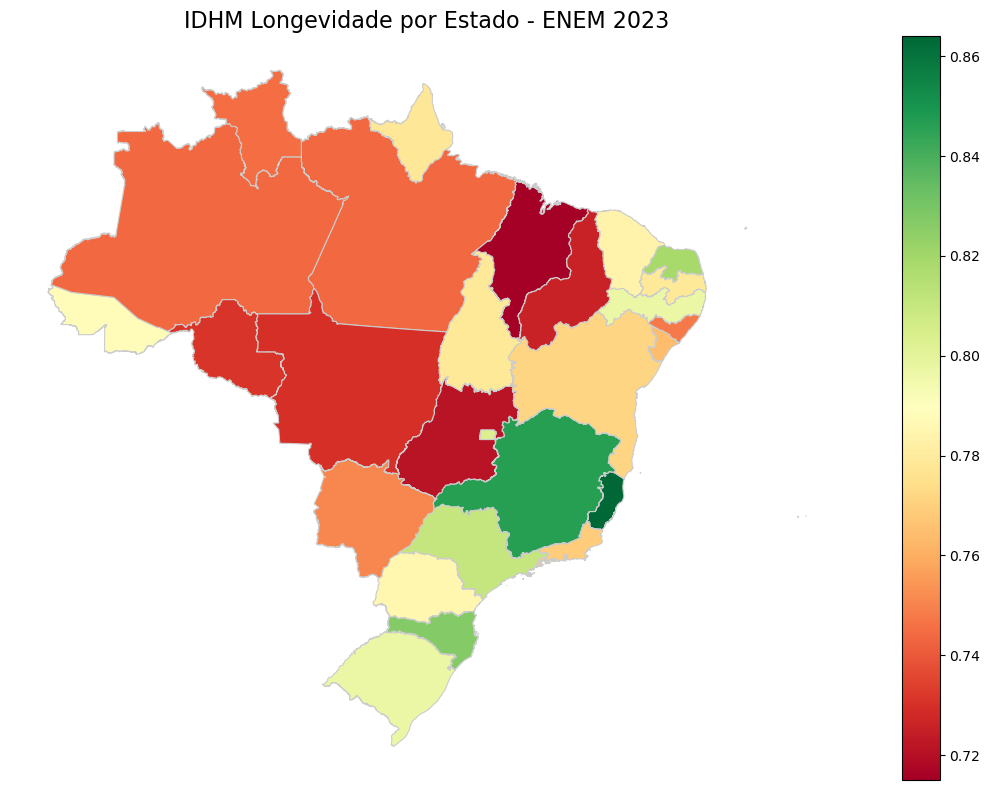

In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

brasil = gpd.read_file("Dados/BR_UF_2024/BR_UF_2024.shp") ##shape file do IBGE: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html

idh_df = pd.read_excel("Dados/DADOS IDH-SIMPLES.xlsx")

# Junta os dados do IDH com o mapa usando a sigla do estado
brasil_idh = brasil.merge(idh_df, on='SIGLA_UF')


# Plota os mapas
for indicador in ['IDHM', 'IDHM Renda', 'IDHM Educação', 'IDHM Longevidade']:
    fig, ax = plt.subplots(figsize=(12, 8))
    brasil_idh.plot(column=indicador, cmap='RdYlGn', linewidth=0.8, edgecolor='0.8',
                    legend=True, ax=ax)

    ax.set_title(f'{indicador} por Estado - ENEM 2023', fontsize=16)
    ax.axis('off')
    plt.tight_layout()

    plt.savefig(f'plots/Mapas/{indicador}_por_UF.png', dpi=300) # Salva o plot na subpaste de plots

    plt.show()

## Código de Clustering para agrupamento de candidatos

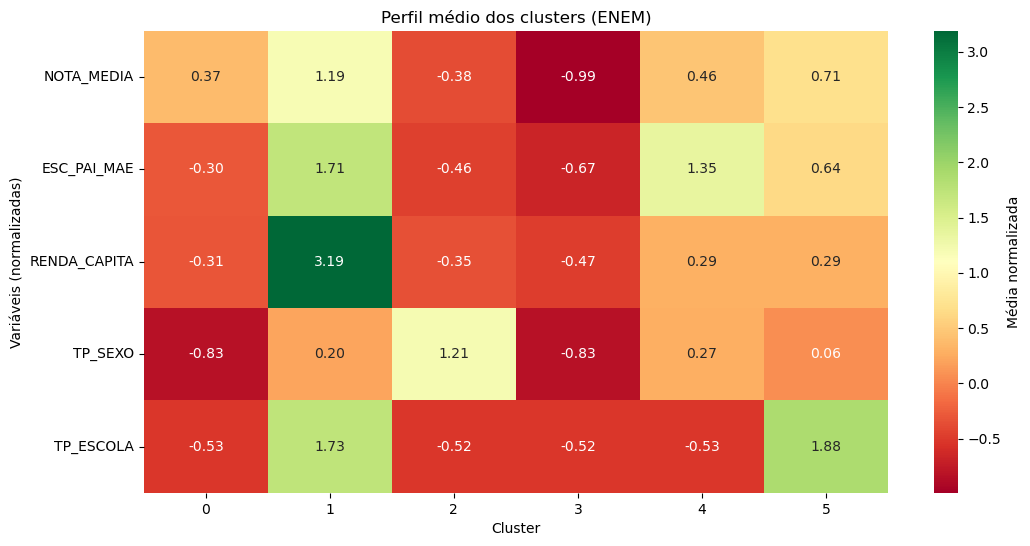

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Número de cluster/agrupamentos
quantidade_de_clusters = 6

# Define as colunas que usaremos no clustering
colunas_notas = ['NOTA_MEDIA']
colunas_extra = [
                    'ESC_PAI_MAE', 'RENDA_CAPITA', 'TP_SEXO', 'TP_ESCOLA'
                 ]  

# Remove linhas com dados faltantes nas colunas que vamos usar
df_cluster = df_enem.dropna(subset=colunas_notas + colunas_extra).copy()

# Converte as variáveis categóricas para números
df_cluster['TP_SEXO'] = LabelEncoder().fit_transform(df_cluster['TP_SEXO'])
df_cluster['TP_ESCOLA'] = LabelEncoder().fit_transform(df_cluster['TP_ESCOLA'])



# Seleciona só as colunas para o clustering
X = df_cluster[colunas_notas + colunas_extra]

# Normaliza as variáveis para terem média 0 e desvio padrão 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Roda KMeans, definindo k (número de grupos) - você pode testar outros valores
k = quantidade_de_clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adiciona o resultado ao dataframe original
df_cluster['cluster'] = clusters

# Transforma os dados normalizados em DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=colunas_notas + colunas_extra)
X_scaled_df['cluster'] = clusters

# Calcula a média de cada variável normalizada por cluster
media_clusters = X_scaled_df.groupby('cluster').mean()

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(media_clusters.T, annot=True, cmap='RdYlGn', cbar_kws={'label': 'Média normalizada'}, fmt=".2f")
plt.title('Perfil médio dos clusters (ENEM)')
plt.ylabel('Variáveis (normalizadas)')
plt.xlabel('Cluster')
plt.savefig('plots/Matrizes/Perfil de Candidatos.png', dpi=300) # Salva o plot na subpaste de plots
plt.show()

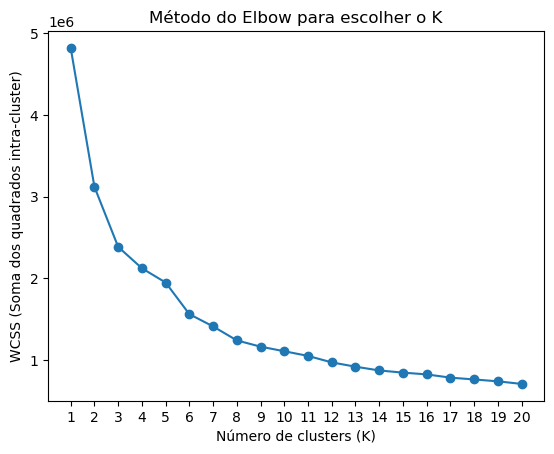

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K_max = 20

for k in range(1, K_max + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ é a soma dos quadrados dentro dos clusters

plt.plot(range(1, K_max + 1), wcss, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('WCSS (Soma dos quadrados intra-cluster)')
plt.title('Método do Elbow para escolher o K')
plt.xticks(range(1, K_max + 1)) # Define os ticks do eixo x explicitamente para mostrar todos os números de 1 a 20
plt.show()

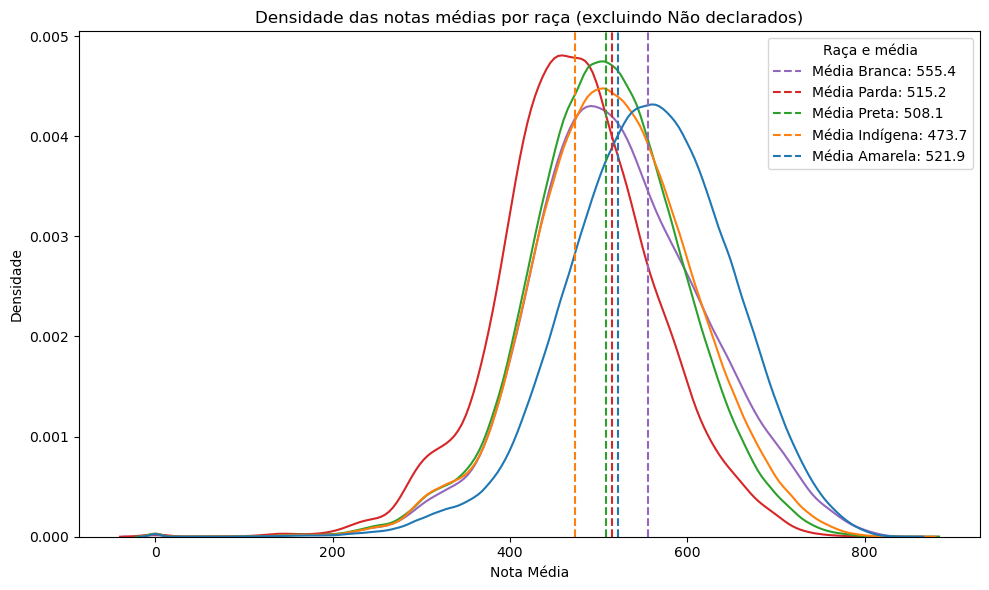

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Mapeamento numérico para nomes das raças
map_raca = {
    0: 'Não declarado',
    1: 'Branca',
    2: 'Preta',
    3: 'Parda',
    4: 'Amarela',
    5: 'Indígena'
}

# Cria cópia do dataframe para não alterar o original
df_plot = df_enem.copy()

# Remove os 'Não declarado' da raça (código 0)
df_plot = df_plot[df_plot['TP_COR_RACA'] != 0]

# Substitui códigos numéricos por nomes das raças
df_plot['RACA_NOME'] = df_plot['TP_COR_RACA'].map(map_raca)

plt.figure(figsize=(10, 6))

# Plota KDE das notas médias, com separação por raça (hue) e salva o eixo
ax = sns.kdeplot(data=df_plot, x='NOTA_MEDIA', hue='RACA_NOME', common_norm=False)

# Lista das raças presentes no df_plot
racas = df_plot['RACA_NOME'].unique()

# Calcula e plota uma linha vertical na média de cada grupo
for linha, raca in zip(ax.get_lines(), racas):
    media = df_plot[df_plot['RACA_NOME'] == raca]['NOTA_MEDIA'].mean()
    cor = linha.get_color()
    plt.axvline(media, color=cor, linestyle='--', linewidth=1.5, label=f'Média {raca}: {media:.1f}')

# Título e rótulos
plt.title('Densidade das notas médias por raça (excluindo Não declarados)')
plt.xlabel('Nota Média')
plt.ylabel('Densidade')

# Atualiza a legenda para incluir as linhas médias
plt.legend(title='Raça e média')
plt.tight_layout()
plt.show()

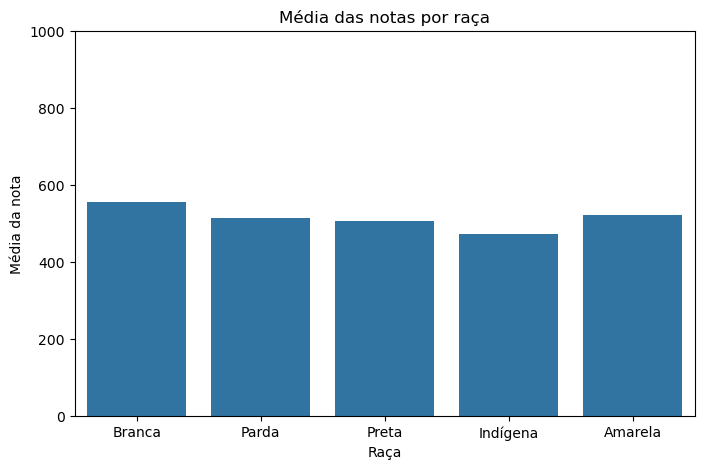

In [71]:
# Gráfico de barras com a média da nota por raça
plt.figure(figsize=(8,5))
media_por_raca = df_plot.groupby('RACA_NOME')['NOTA_MEDIA'].mean().reindex(racas)
sns.barplot(x=media_por_raca.index, y=media_por_raca.values)
plt.title('Média das notas por raça')
plt.xlabel('Raça')
plt.ylabel('Média da nota')
plt.ylim(0, 1000)  # Ajuste o limite conforme sua escala de nota
plt.show()

In [24]:
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd

# Mapeia raças
map_raca = {
    0: 'Não declarado',
    1: 'Branca',
    2: 'Preta',
    3: 'Parda',
    4: 'Amarela',
    5: 'Indígena'
}

# Prepara os dados: filtra "não declarado" e mapeia nome da raça
df_plot = df_enem[df_enem['TP_COR_RACA'].isin(map_raca.keys())].copy()
df_plot['RACA_NOME'] = df_plot['TP_COR_RACA'].map(map_raca)

# Gera figura
fig = go.Figure()

# Adiciona uma linha para cada raça
for raca, nome in map_raca.items():
    dados = df_plot[df_plot['TP_COR_RACA'] == raca]['NOTA_MEDIA'].dropna()
    if len(dados) < 2:
        continue  # pula se não houver dados suficientes para KDE
    
    kde = gaussian_kde(dados)
    x_vals = np.linspace(dados.min(), dados.max(), 200)
    y_vals = kde(x_vals)

    fig.add_trace(go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='lines',
        name=nome,
        visible=True
    ))

# Layout interativo
fig.update_layout(
    title="Distribuição das notas médias por raça (KDE interativo)",
    xaxis_title="Nota Média",
    yaxis_title="Densidade",
    hovermode="x unified"
)

fig.show()

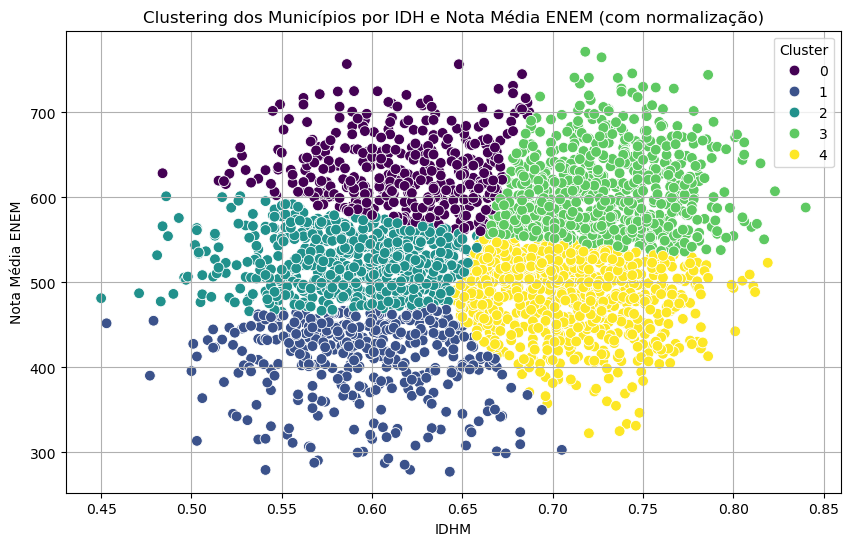

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import unidecode


num_clusters = 5

# Carrega os dados do censo por município:
idh_m = pd.read_csv("mundo_onu_adh_municipio.csv.gz", sep=',', encoding='latin1')

# Carrega o tradutor de nomes de municípios:
tradutor = pd.read_csv("br_bd_diretorios_brasil_municipio.csv.gz", sep=',', encoding='latin1')

# Coloca os nomes dos municípios no df idh_m:
idh_m = idh_m.merge(tradutor, left_on='id_municipio', right_on='id_municipio', how='left')

# Filtra os dados do IDH para o ano de 2010:
idh_m = idh_m.query('ano == 2010')

df_enem[df_enem['NO_MUNICIPIO_ESC'] == 'São Paulo']['NOTA_MEDIA'].mean()

# Merge com dados do ENEM
#idh_m['nome'] = idh_m['nome'].astype(str).str.upper().str.strip().apply(unidecode.unidecode)
#df_enem['NO_MUNICIPIO_ESC'] = df_enem['NO_MUNICIPIO_ESC'].astype(str).str.upper().str.strip().apply(unidecode.unidecode)

df_merged = pd.merge(idh_m, df_enem, left_on='nome', right_on='NO_MUNICIPIO_ESC', how='inner')



# Filtros
df_merged = df_merged.drop_duplicates(subset='nome', keep='first')
df_merged = df_merged[df_merged['idhm'] > 0]
#df_merged = df_merged[df_merged['populacao'] > 50000]


# Clustering com normalização
df_cluster = df_merged[['NOTA_MEDIA', 'idhm']].dropna()

# Normaliza os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


# KMeans com 6 clusters NÃO NORMALIZADO
#kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(df_cluster)

# KMeans com 6 clusters NORMALIZADAS
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adiciona os clusters ao DataFrame original (não normalizado)
df_cluster = df_cluster.copy()
df_cluster['cluster'] = clusters

# Visualização
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_cluster, x='idhm', y='NOTA_MEDIA', hue='cluster', palette='viridis', s=60)
plt.title('Clustering dos Municípios por IDH e Nota Média ENEM (com normalização)')
plt.xlabel('IDHM')
plt.ylabel('Nota Média ENEM')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [4]:
# Carrega os dados do censo por município:
idh_m = pd.read_csv("mundo_onu_adh_municipio.csv.gz", sep=',', encoding='utf-8')

# Carrega o tradutor de nomes de municípios:
tradutor = pd.read_csv("br_bd_diretorios_brasil_municipio.csv.gz", sep=',', encoding='utf-8')

# Junta os nomes
idh_m = idh_m.merge(tradutor, on='id_municipio', how='left')


# Filtra para o ano de 2010
idh_m = idh_m.query('ano == 2010')

# Merge com os dados do ENEM
#idh_m['nome'] = idh_m['nome'].astype(str).str.upper().str.strip().apply(unidecode.unidecode)
#df_enem['NO_MUNICIPIO_ESC'] = df_enem['NO_MUNICIPIO_ESC'].astype(str).str.upper().str.strip().apply(unidecode.unidecode)
df_merged = pd.merge(idh_m, df_enem, left_on='nome', right_on='NO_MUNICIPIO_ESC', how='inner')
df_merged = df_merged.sort_values(by='nome')


    
# Filtros
df_merged = df_merged.drop_duplicates(subset='nome', keep='first')
df_merged = df_merged[df_merged['idhm'] > 0]
#df_merged = df_merged[df_merged['populacao'] > 1000000]
#print(df_merged[df_merged['id_municipio'] == 3550308])

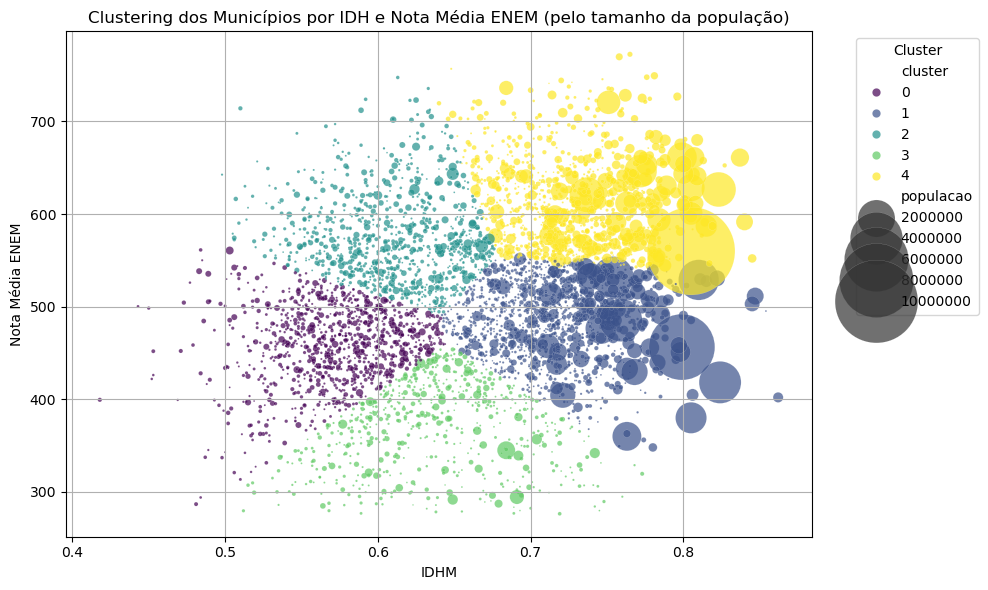

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import unidecode

df_enem[df_enem['NO_MUNICIPIO_ESC'] == 'São Paulo']['NOTA_MEDIA'].mean()

num_clusters = 5


# Seleciona colunas para cluster + população
df_cluster = df_merged[['NOTA_MEDIA', 'idhm', 'populacao']].dropna()


# Normaliza as variáveis (exceto população)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[['NOTA_MEDIA', 'idhm']])

# KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adiciona os clusters e população de volta
df_cluster = df_cluster.copy()
df_cluster['cluster'] = clusters

# Visualização com tamanho dos pontos proporcional à população
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_cluster,
    x='idhm',
    y='NOTA_MEDIA',
    hue='cluster',
    size='populacao',
    sizes=(1, 4000),  # escala do tamanho dos pontos
    palette='viridis',
    alpha=0.7
)
plt.title('Clustering dos Municípios por IDH e Nota Média ENEM (pelo tamanho da população)')
plt.xlabel('IDHM')
plt.ylabel('Nota Média ENEM')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/Mapas/Mapa de IDH por nota e população.png', dpi=300) # Salva o plot na subpaste de plots
plt.show()

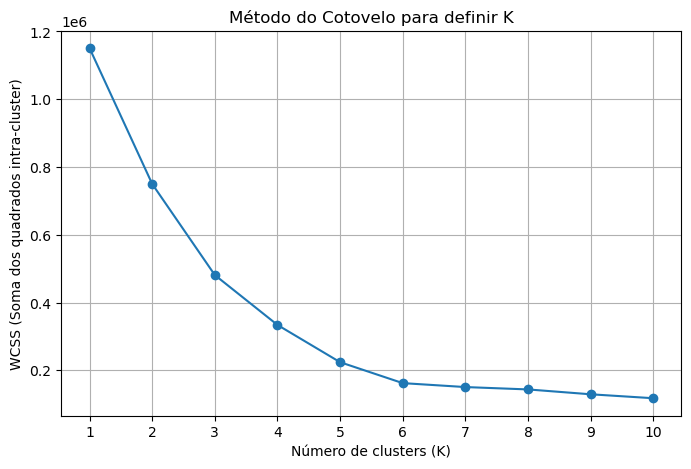

In [11]:
from sklearn.preprocessing import StandardScaler


# Normaliza os dados antes do clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Método do cotovelo
wcss = []
K_max = 10  # Você pode ajustar esse valor para testar mais ou menos clusters

for k in range(1, K_max + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot do Elbow
plt.figure(figsize=(8, 5))
plt.plot(range(1, K_max + 1), wcss, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('WCSS (Soma dos quadrados intra-cluster)')
plt.title('Método do Cotovelo para definir K')
plt.xticks(range(1, K_max + 1))
plt.grid(True)
plt.show()